# Instruct-Seg-Edit

### A mini-project by KP Sai Praneeth - 230968248

## Preprocessing

Dataset: tomg-group-umd/pixelprose (Reference: https://huggingface.co/datasets/tomg-group-umd/pixelprose, https://huggingface.co/papers/2406.10328)

The actual dataset for training the model is derived from this dataset.

### Data Loading

First, we load the dataset to examine its structure and contents. This parquet file contains image URLs and their corresponding captions from the PixelProse dataset.

In [1]:
# Load and display first few rows of parquet dataset
import pandas as pd

df = pd.concat([pd.read_parquet("data/vlm_captions_redcaps_00.parquet"), pd.read_parquet("data/vlm_captions_redcaps_01.parquet")])
df.head()

,uid,url,key,status,original_caption,vlm_model,vlm_caption,toxicity,severe_toxicity,obscene,...,width,height,original_width,original_height,exif,sha256,image_id,author,subreddit,score
0,052e2c7503cb4a29adeaaf466bb13aaa032f2ba3595a11...,https://i.redd.it/vx27ik897yyx.jpg,007740042,success,"best hiking spot on ice mountains, you really ...",gemini-1.0-pro-vision-latest,This image displays: a group of nine mountain...,0.000460,0.000001,0.000027,...,1365,1024,1080,810,{},052e2c7503cb4a29adeaaf466bb13aaa032f2ba3595a11...,5e3con,renoviolaoutdoors66,242,2.0
1,a7754f30f5d2a9eb83815b47190aae863affdcda1cb849...,https://i.redd.it/q9evvjgqdazx.jpg,007740047,success,deep boundary waters. spent 12 days here and s...,gemini-1.0-pro-vision-latest,This image displays: a wide shot of a lake. T...,0.002076,0.000007,0.000070,...,1024,1365,2448,3264,{},a7754f30f5d2a9eb83815b47190aae863affdcda1cb849...,5ef2uw,None,242,172.0
2,343ddd9cf33ed49dda62b1171c69b733f77578a2fbff38...,https://i.redd.it/fgxweplt8wxx.jpg,007740028,success,"sunset paddle - bar harbor, me",gemini-1.0-pro-vision-latest,This image displays four people kayaking in t...,0.000510,0.000002,0.000029,...,1536,1024,6000,4000,{},343ddd9cf33ed49dda62b1171c69b733f77578a2fbff38...,5d6sm4,kayakguy429,242,5.0
3,1189f217664d4f82495bd25a6e0a734b538281376524d6...,https://i.redd.it/23v2mbs6x6xx.jpg,007740016,success,"meanwhile in south korea, hundreds of thousand...",gemini-1.0-pro-vision-latest,This image displays: A large crowd of people ...,0.000444,0.000001,0.000030,...,1535,1024,940,627,{},1189f217664d4f82495bd25a6e0a734b538281376524d6...,5cke9b,PresidentBananas,242,5.0
4,a8ab52803f9d8e1fbea55c77370f12f7ae84de31ced9bd...,https://i.redd.it/xzsvyn5sdawx.jpg,007740002,success,sweet pepper display in a grocery store,gemini-1.0-pro-vision-latest,This image displays:\n\nThe image displays a ...,0.000529,0.000001,0.000033,...,1365,1024,3264,2448,{},a8ab52803f9d8e1fbea55c77370f12f7ae84de31ced9bd...,5bpv0z,microfortnight,242,14.0


### Image Download Function

We need a function to download images from URLs and prepare them for processing. This function handles image validation, resizing, and saving to local storage.

In [2]:
# Download, resize and save images from URLs
from PIL import Image
import requests
from io import BytesIO

def image_path_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    if img.size == (130, 60):  # Skip invalid/placeholder images
        return None
    img = img.resize((512, 512))  # Standardize size
    img_path = url.split("/")[-1]
    img.save(f"data/images/{img_path}")
    return f"data/images/{img_path}"

### LLM Prompt Template

To generate edit instructions automatically, we define a structured prompt that guides the language model to create specific, actionable editing commands based on image captions.

In [3]:
# Template prompt for generating image edit instructions
prompt = """
**Task:** You are an expert in creating image editing instructions. Your goal is to analyze an image and its accompanying caption to generate a concise instruction that describes a specific, tangible edit to the main subject of the image.

**Instructions:**
1.  **Focus on the Subject:** The edit instruction must apply *only* to the primary subject of the image.
2.  **Describe the Action:** The instruction should describe a clear action or transformation based on the caption.
3.  **Be Concise:** Output only the edit instruction itself, with no extra text, labels, or explanations.
4.  **Exclude:** Do not mention changes to the background, lighting, contrast, saturation, or overall image style.

---
**Example:**

**Input Caption:**
A photo of a cat. The cat is wearing a party hat.

**Generated Instruction:**
Add a party hat to the cat.
---

"""

### Generate Edit Instructions

Using the LM Studio client, we process sample images and their captions to generate edit instructions. This creates the foundation for our instruction-following image editing dataset.

In [ ]:
# Generate edit instructions using LLM for sample images
import lmstudio as lms
from IPython.display import display
from tqdm.notebook import tqdm

client = lms.get_default_client()
llm = client.llm.load_new_instance("gemma-3-4b-it")

data_head: list[dict] = []

for row in tqdm(df.iterrows(), total=len(df), desc="Generating edit instructions"):
    idx, data = row
    img_url = data["url"]
    caption = data["vlm_caption"] + "\n" + data["original_caption"]  # Combine captions
    img_path = image_path_from_url(img_url)
    if img_path is None:
        print(f"{img_url} is not a valid image.")
        continue
    # display(Image.open(img_path).convert("RGB"))
    
    # Send image and caption to LLM for edit instruction generation
    chat = lms.Chat()
    image_handle = lms.prepare_image(img_path)
    chat.add_user_message(prompt + caption, images=[image_handle])
    prediction = llm.respond(chat)
    # print(f"Image: {img_path}\nCaption: {caption}\nPrompt: {prediction}\n")
    
    # Store results
    data_head.append({
        "image": img_path,
        "caption": caption,
        "edit_instruction": prediction.content
    })

llm.unload()

Generating edit instructions:   0%|          | 0/1290861 [00:00<?, ?it/s]

https://i.redd.it/23v2mbs6x6xx.jpg is not a valid image.


KeyboardInterrupt: 

{"event": "Websocket failed, terminating session.", "ws_url": "ws://127.0.0.1:41343/llm"}
{"event": "Websocket failed, terminating session.", "ws_url": "ws://127.0.0.1:41343/files"}


### Apply Edits with InstructPix2Pix

Now we use the InstructPix2Pix model to actually perform the image edits based on the generated instructions. This creates the "after" images for our dataset.

In [ ]:
# Apply edit instructions using InstructPix2Pix model
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler
import os

model_path = "./models/instruct-pix2pix"

# Load and configure the editing pipeline
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    model_path,
    torch_dtype=torch.float16,
    safety_checker=None,
    local_files_only=True
)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)
pipe.set_progress_bar_config(disable=True)

# Process images in batches
batch_size = 2
for i in tqdm(range(0, len(data_head), batch_size)):
    batch_data = data_head[i:i + batch_size]
    original_images = [Image.open(item["image"]).convert("RGB") for item in batch_data]
    image_batch = [img.resize((224, 224)) for img in original_images]  # Resize for model
    prompt_batch = [item["edit_instruction"] for item in batch_data]

    # Generate edited images
    images_out = pipe(
        prompt=prompt_batch,
        image=image_batch,
        num_inference_steps=40,
        guidance_scale=7.5
    ).images

    # Save results with original dimensions
    for j, image in enumerate(images_out):
        original_image = original_images[j]
        original_name = os.path.basename(batch_data[j]["image"])
        stretched_image = image.resize(original_image.size, Image.Resampling.LANCZOS)
        stretched_image.save(os.path.join(".\\data\\results", f"{original_name}"))

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_instruct_pix2pix.StableDiffusionInstructPix2PixPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/2 [00:00<?, ?it/s]

### View Generated Results

Let's examine the edited images produced by the InstructPix2Pix model to assess the quality of the edits.

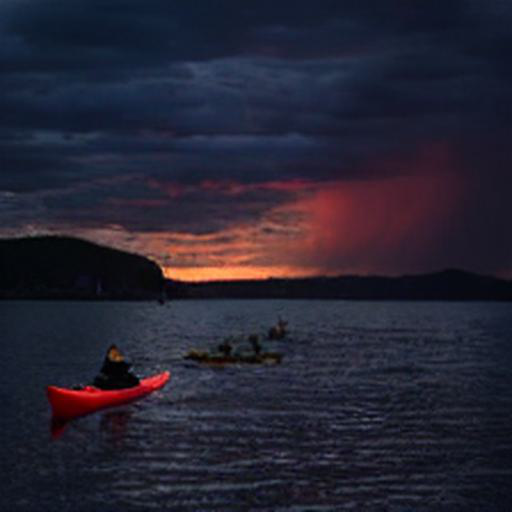

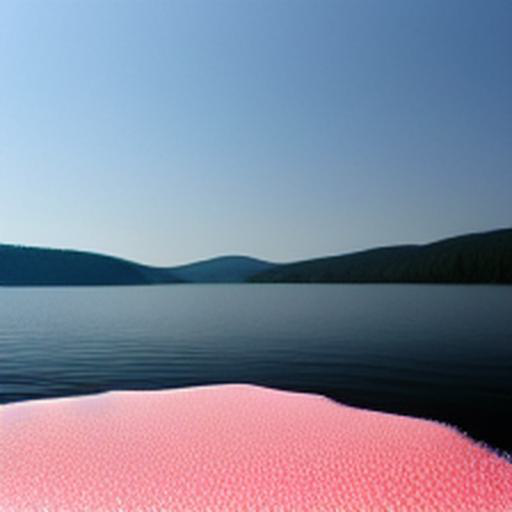

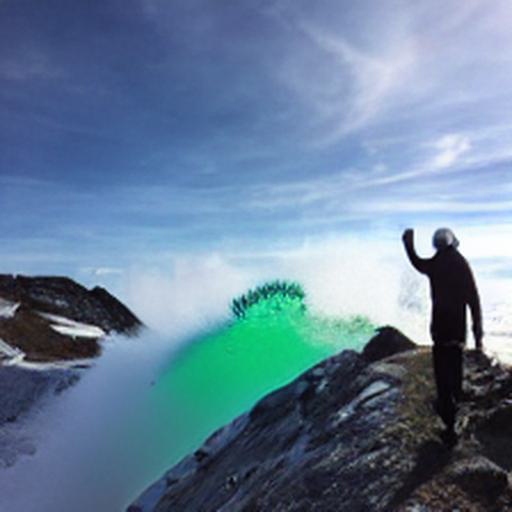

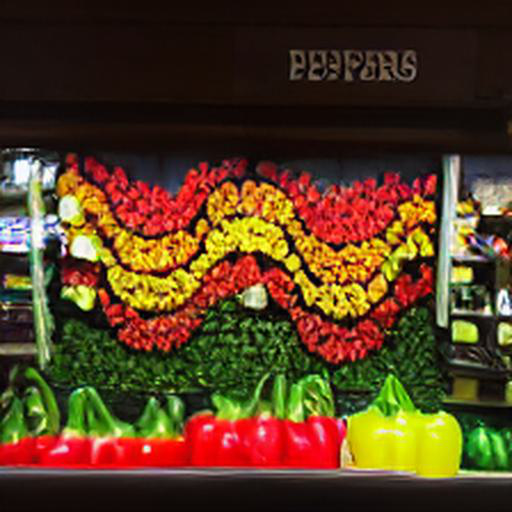

In [ ]:
# Display all generated result images
from glob import glob

result_images = glob("data/results/*.jpg")
for img_path in result_images:
    display(Image.open(img_path).convert("RGB"))

### Generate Edit Masks

To create segmentation masks showing which parts of the image were modified, we compare the original and edited images pixel by pixel. These masks are crucial for training segmentation models.

Generating edit maps:   0%|          | 0/4 [00:00<?, ?it/s]

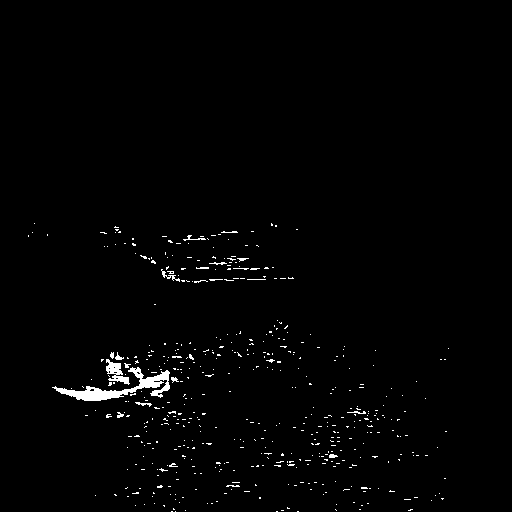

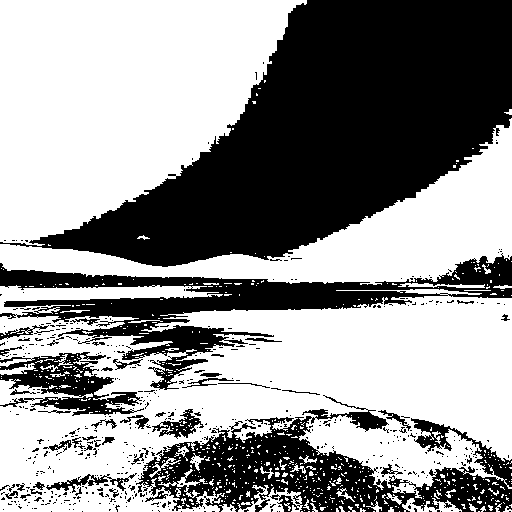

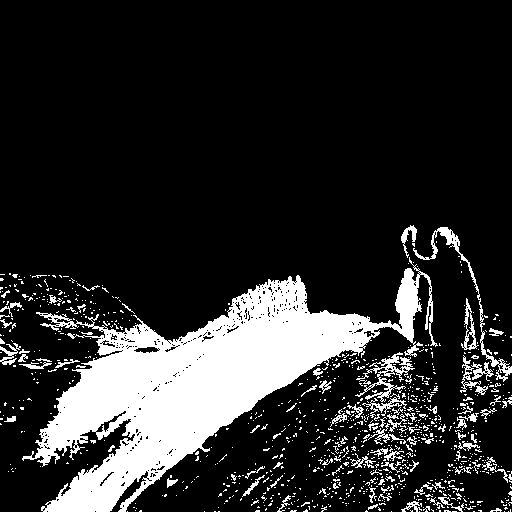

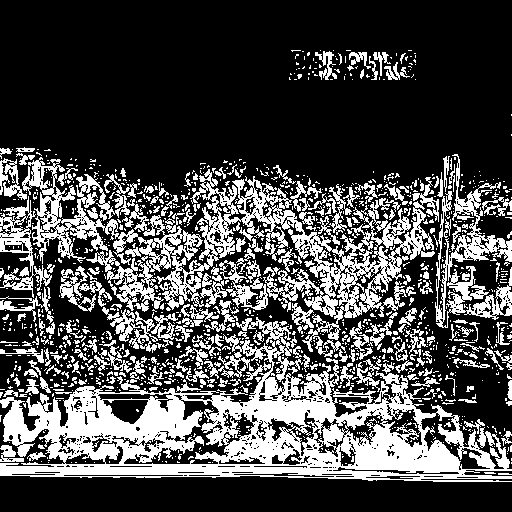

In [ ]:
# Generate edit masks by comparing original and edited images
import cv2

original_images = glob("data\\images\\*.jpg")
edited_images = glob("data\\results\\*.jpg")

# Match original and edited images by filename
mapping = [(orig, edit) for orig in original_images for edit in edited_images if os.path.basename(orig) == os.path.basename(edit)]
original_images, edited_images = zip(*mapping)

for paths in tqdm(zip(original_images, edited_images), desc="Generating edit maps", total=len(original_images)):
    original_image = cv2.imread(paths[0])
    edited_image = cv2.imread(paths[1])
    if original_image is None or edited_image is None:
        print(f"Warning: Could not load image(s): {paths[0]}, {paths[1]}")
        continue
    if original_image.shape != edited_image.shape:
        print(f"Warning: Image shapes do not match: {paths[0]}, {paths[1]}")
        continue
    
    # Convert to grayscale and compute difference
    original_gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    edited_gray = cv2.cvtColor(edited_image, cv2.COLOR_BGR2GRAY)
    diff_gray = cv2.absdiff(original_gray, edited_gray)
    
    # Create binary mask from differences
    _, mask = cv2.threshold(diff_gray, 30, 255, cv2.THRESH_BINARY)
    cv2.imwrite(f"data\\masks\\{os.path.basename(paths[0])}", mask)
    display(Image.fromarray(mask))

## Exploratory Data Analysis

### Analysis of Captions

In [2]:
# Basic statistics and text analysis of captions
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Basic dataset info
print(f"Total samples: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few samples:")
print(df[['original_caption', 'vlm_caption']].head())

# Check for missing values
print(f"\nMissing values:")
print(f"Original captions: {df['original_caption'].isna().sum()}")
print(f"VLM captions: {df['vlm_caption'].isna().sum()}")

# Basic text statistics
df['original_length'] = df['original_caption'].str.len()
df['vlm_length'] = df['vlm_caption'].str.len()
df['original_words'] = df['original_caption'].str.split().str.len()
df['vlm_words'] = df['vlm_caption'].str.split().str.len()

print(f"\nText Length Statistics:")
print(f"Original caption length - Mean: {df['original_length'].mean():.1f}, Median: {df['original_length'].median():.1f}")
print(f"VLM caption length - Mean: {df['vlm_length'].mean():.1f}, Median: {df['vlm_length'].median():.1f}")
print(f"Original word count - Mean: {df['original_words'].mean():.1f}, Median: {df['original_words'].median():.1f}")
print(f"VLM word count - Mean: {df['vlm_words'].mean():.1f}, Median: {df['vlm_words'].median():.1f}")

Total samples: 1290861
Columns: ['uid', 'url', 'key', 'status', 'original_caption', 'vlm_model', 'vlm_caption', 'toxicity', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit', 'watermark_class_id', 'watermark_class_score', 'aesthetic_score', 'error_message', 'width', 'height', 'original_width', 'original_height', 'exif', 'sha256', 'image_id', 'author', 'subreddit', 'score']

First few samples:
                                    original_caption  \
0  best hiking spot on ice mountains, you really ...   
1  deep boundary waters. spent 12 days here and s...   
2                     sunset paddle - bar harbor, me   
3  meanwhile in south korea, hundreds of thousand...   
4            sweet pepper display in a grocery store   

                                         vlm_caption  
0   This image displays: a group of nine mountain...  
1   This image displays: a wide shot of a lake. T...  
2   This image displays four people kayaking in t...  
3   This i

### Length Distribution Comparison

C:\Users\pc\AppData\Local\Temp\ipykernel_15468\1954086071.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot(box_data, labels=['Original', 'VLM'])
C:\Users\pc\AppData\Local\Temp\ipykernel_15468\1954086071.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,1].boxplot(box_data_words, labels=['Original', 'VLM'])


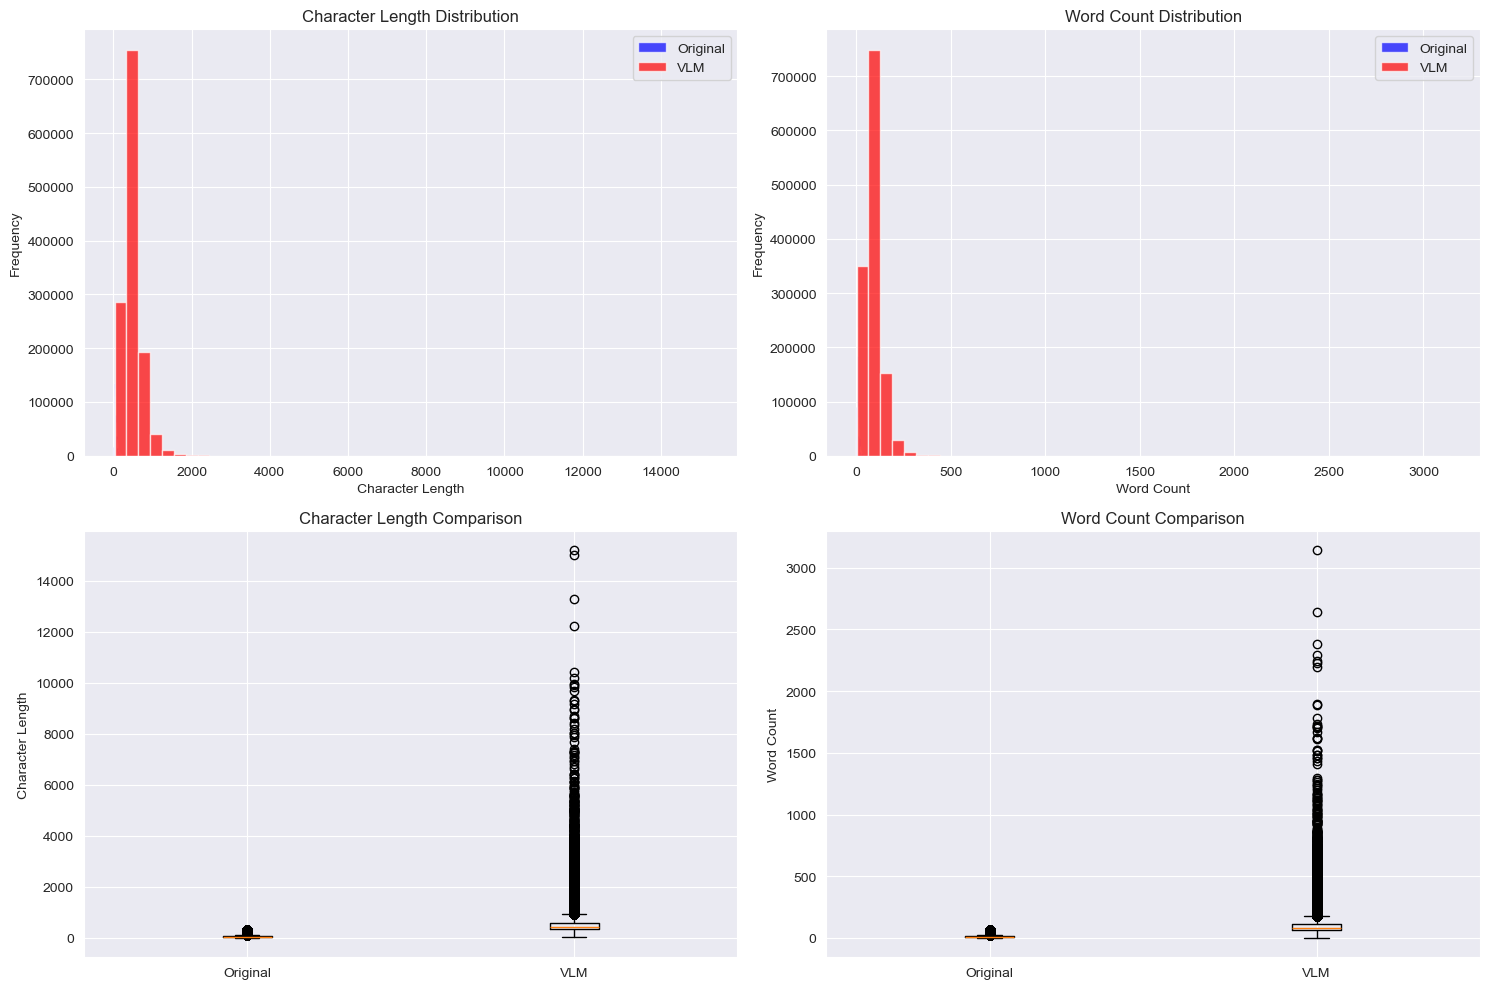

In [3]:
# Visualize length distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distributions
axes[0,0].hist(df['original_length'], bins=50, alpha=0.7, label='Original', color='blue')
axes[0,0].hist(df['vlm_length'], bins=50, alpha=0.7, label='VLM', color='red')
axes[0,0].set_xlabel('Character Length')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_title('Character Length Distribution')
axes[0,0].legend()

# Word count distributions
axes[0,1].hist(df['original_words'], bins=50, alpha=0.7, label='Original', color='blue')
axes[0,1].hist(df['vlm_words'], bins=50, alpha=0.7, label='VLM', color='red')
axes[0,1].set_xlabel('Word Count')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Word Count Distribution')
axes[0,1].legend()

# Box plots for comparison
box_data = [df['original_length'], df['vlm_length']]
axes[1,0].boxplot(box_data, labels=['Original', 'VLM'])
axes[1,0].set_ylabel('Character Length')
axes[1,0].set_title('Character Length Comparison')

box_data_words = [df['original_words'], df['vlm_words']]
axes[1,1].boxplot(box_data_words, labels=['Original', 'VLM'])
axes[1,1].set_ylabel('Word Count')
axes[1,1].set_title('Word Count Comparison')

plt.tight_layout()
plt.show()

### Most Frequent Words Analysis

Top 20 words in Original Captions:
the: 384003
a: 333227
my: 285771
i: 276298
in: 216685
of: 199077
and: 196741
to: 196514
this: 187677
is: 133971
s: 122299
it: 117048
for: 116681
on: 113824
with: 96660
first: 73785
at: 69712
from: 61744
but: 53147
new: 49903

Top 20 words in VLM Captions:
the: 12636377
a: 8439807
is: 6156534
and: 4614951
of: 3731772
in: 2980718
on: 2795076
image: 2664218
with: 2561823
there: 1711841
are: 1587625
white: 1386666
this: 1378735
displays: 1319845
background: 1020710
black: 977441
has: 928967
it: 883500
to: 865593
its: 758117


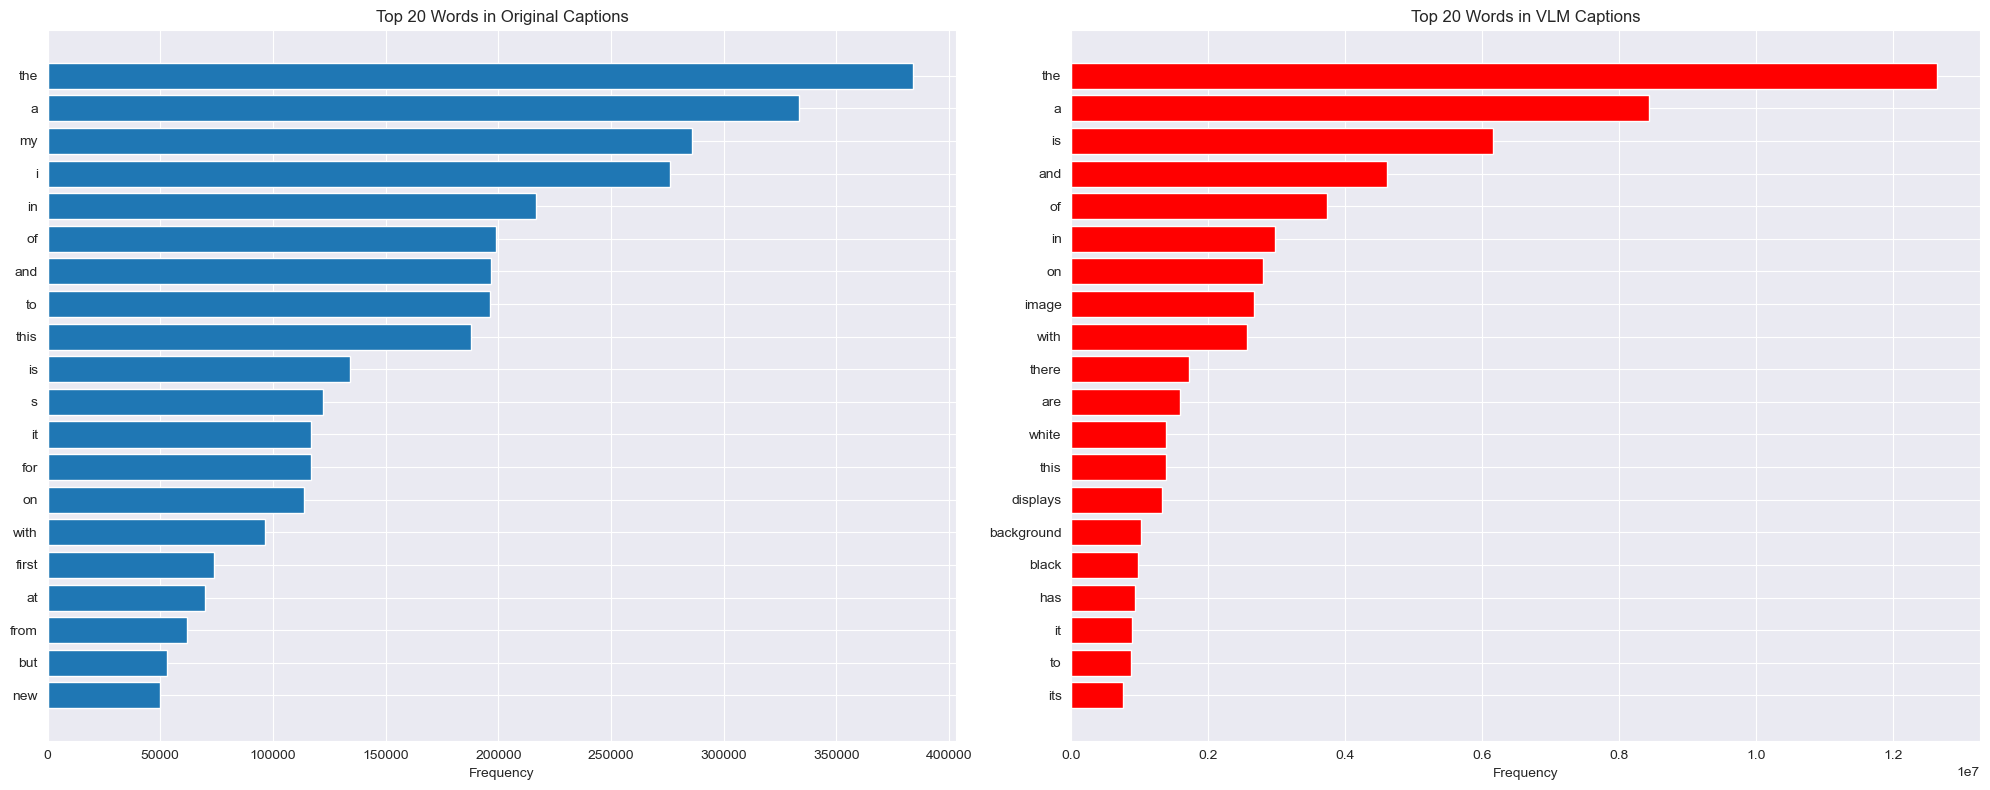

In [4]:
# Word frequency analysis
from collections import Counter
import re

def get_word_frequencies(text_series, top_n=20):
    """Extract word frequencies from text series"""
    all_text = ' '.join(text_series.dropna().astype(str))
    # Clean text: lowercase, remove punctuation
    words = re.findall(r'\b[a-zA-Z]+\b', all_text.lower())
    return Counter(words).most_common(top_n)

# Get top words for both caption types
original_words = get_word_frequencies(df['original_caption'])
vlm_words = get_word_frequencies(df['vlm_caption'])

print("Top 20 words in Original Captions:")
for word, count in original_words:
    print(f"{word}: {count}")

print("\nTop 20 words in VLM Captions:")
for word, count in vlm_words:
    print(f"{word}: {count}")

# Create comparison visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Original captions word frequency
orig_words, orig_counts = zip(*original_words)
ax1.barh(range(len(orig_words)), orig_counts)
ax1.set_yticks(range(len(orig_words)))
ax1.set_yticklabels(orig_words)
ax1.set_xlabel('Frequency')
ax1.set_title('Top 20 Words in Original Captions')
ax1.invert_yaxis()

# VLM captions word frequency
vlm_words_list, vlm_counts = zip(*vlm_words)
ax2.barh(range(len(vlm_words_list)), vlm_counts, color='red')
ax2.set_yticks(range(len(vlm_words_list)))
ax2.set_yticklabels(vlm_words_list)
ax2.set_xlabel('Frequency')
ax2.set_title('Top 20 Words in VLM Captions')
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

### Caption Similarity Analysis

Caption Similarity Statistics (sample of 1000):
Mean similarity: 0.174
Median similarity: 0.053
Std similarity: 0.221
Min similarity: 0.000
Max similarity: 0.834


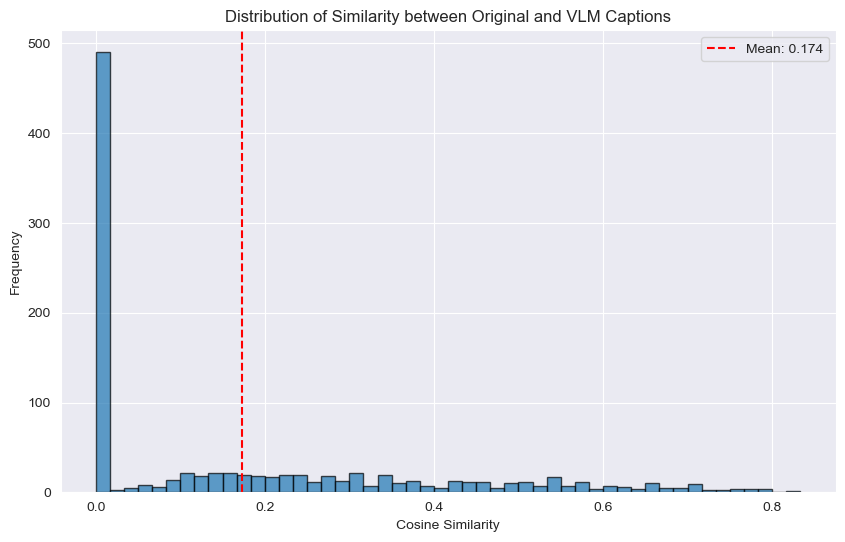


Examples of HIGH similarity pairs:
Similarity: 0.834
Original: bloody mary burger
VLM:  This image displays a plate with a burger, fries, and ketchup on a wooden table. The burger is on top of the fries. The burger has a fried egg, cheese, and bacon on it. The fries are in a pile next to the burger. The ketchup is in a metal container. The plate is tan. The table is dark brown.

Similarity: 0.826
Original: moon 3-3-2020 from kansas
VLM:  This image displays the moon in its first quarter phase, commonly known as a half moon. The moon's surface is covered in craters and maria, which are large, dark plains formed by ancient volcanic activity. The moon is set against a black background, with no stars or other objects visible. The image is a photograph, likely taken through a telescope.

Similarity: 0.788
Original: folding bike from brazil
VLM:  This image displays a red and black folding bike. The bike is made of metal and has a black seat and black handlebars. The wheels are red with sil

In [5]:
# Compare similarity between original and VLM captions
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sample a subset for similarity analysis (full dataset might be too large)
sample_size = min(1000, len(df))
df_sample = df.sample(n=sample_size, random_state=42)

# Calculate cosine similarity between original and VLM captions
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit on combined text to ensure same vocabulary
all_captions = pd.concat([df_sample['original_caption'], df_sample['vlm_caption']])
vectorizer.fit(all_captions.fillna(''))

# Transform both caption types
original_vectors = vectorizer.transform(df_sample['original_caption'].fillna(''))
vlm_vectors = vectorizer.transform(df_sample['vlm_caption'].fillna(''))

# Calculate pairwise similarities
similarities = []
for i in range(len(df_sample)):
    sim = cosine_similarity(original_vectors[i], vlm_vectors[i])[0][0]
    similarities.append(sim)

df_sample['similarity'] = similarities

print(f"Caption Similarity Statistics (sample of {sample_size}):")
print(f"Mean similarity: {np.mean(similarities):.3f}")
print(f"Median similarity: {np.median(similarities):.3f}")
print(f"Std similarity: {np.std(similarities):.3f}")
print(f"Min similarity: {np.min(similarities):.3f}")
print(f"Max similarity: {np.max(similarities):.3f}")

# Visualize similarity distribution
plt.figure(figsize=(10, 6))
plt.hist(similarities, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Similarity between Original and VLM Captions')
plt.axvline(np.mean(similarities), color='red', linestyle='--', label=f'Mean: {np.mean(similarities):.3f}')
plt.legend()
plt.show()

# Show examples of high and low similarity pairs
print("\nExamples of HIGH similarity pairs:")
high_sim = df_sample.nlargest(3, 'similarity')
for idx, row in high_sim.iterrows():
    print(f"Similarity: {row['similarity']:.3f}")
    print(f"Original: {row['original_caption']}")
    print(f"VLM: {row['vlm_caption']}\n")

print("Examples of LOW similarity pairs:")
low_sim = df_sample.nsmallest(3, 'similarity')
for idx, row in low_sim.iterrows():
    print(f"Similarity: {row['similarity']:.3f}")
    print(f"Original: {row['original_caption']}")
    print(f"VLM: {row['vlm_caption']}\n")

### Unique Words and Vocabulary Analysis

Vocabulary Analysis:
Original caption vocabulary size: 166,237
VLM caption vocabulary size: 151,215
Common words: 91,310
Words only in original: 74,927
Words only in VLM: 59,905
Vocabulary overlap: 0.404


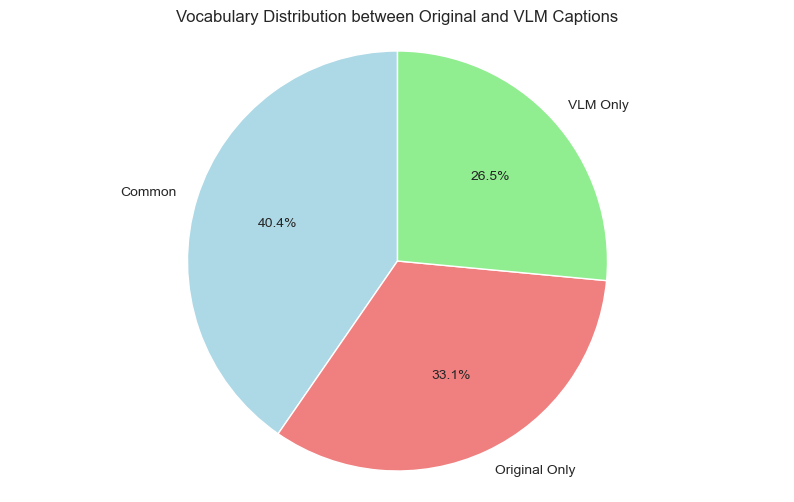


Sample words only in original captions: ['undooperative', 'daying', 'delvine', 'albuns', 'poofball', 'drachenfels', 'deliberative', 'tolerable', 'interresring', 'opalines', 'sproings', 'saoseo', 'cbslocal', 'muckish', 'feralstank', 'rmr', 'kemerovo', 'heliophanus', 'paaaaancakesssss', 'sweathouse']

Sample words only in VLM captions: ['elsira', 'dancerk', 'dosbarth', 'urbis', 'gestell', 'supremo', 'joies', 'eln', 'boltor', 'chicagoemporium', 'srixon', 'collett', 'marlinshipping', 'edgewoodautosales', 'jelo', 'joeblow', 'kria', 'zarrelli', 'duboeuf', 'westheimer']

Unique words per caption:
Original - Mean: 9.0, Median: 7.0
VLM - Mean: 53.9, Median: 51.0


In [6]:
# Vocabulary comparison between original and VLM captions
def get_vocabulary(text_series):
    """Get unique words from text series"""
    all_text = ' '.join(text_series.dropna().astype(str))
    words = set(re.findall(r'\b[a-zA-Z]+\b', all_text.lower()))
    return words

original_vocab = get_vocabulary(df['original_caption'])
vlm_vocab = get_vocabulary(df['vlm_caption'])

# Calculate vocabulary statistics
common_words = original_vocab.intersection(vlm_vocab)
original_only = original_vocab - vlm_vocab
vlm_only = vlm_vocab - original_vocab

print("Vocabulary Analysis:")
print(f"Original caption vocabulary size: {len(original_vocab):,}")
print(f"VLM caption vocabulary size: {len(vlm_vocab):,}")
print(f"Common words: {len(common_words):,}")
print(f"Words only in original: {len(original_only):,}")
print(f"Words only in VLM: {len(vlm_only):,}")
print(f"Vocabulary overlap: {len(common_words)/len(original_vocab.union(vlm_vocab)):.3f}")

# Visualize vocabulary overlap
labels = ['Common', 'Original Only', 'VLM Only']
sizes = [len(common_words), len(original_only), len(vlm_only)]
colors = ['lightblue', 'lightcoral', 'lightgreen']

plt.figure(figsize=(10, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Vocabulary Distribution between Original and VLM Captions')
plt.axis('equal')
plt.show()

# Show examples of unique words
print(f"\nSample words only in original captions: {list(original_only)[:20]}")
print(f"\nSample words only in VLM captions: {list(vlm_only)[:20]}")

# Analyze caption complexity
df['original_unique_words'] = df['original_caption'].apply(lambda x: len(set(str(x).lower().split())) if pd.notna(x) else 0)
df['vlm_unique_words'] = df['vlm_caption'].apply(lambda x: len(set(str(x).lower().split())) if pd.notna(x) else 0)

print(f"\nUnique words per caption:")
print(f"Original - Mean: {df['original_unique_words'].mean():.1f}, Median: {df['original_unique_words'].median():.1f}")
print(f"VLM - Mean: {df['vlm_unique_words'].mean():.1f}, Median: {df['vlm_unique_words'].median():.1f}")

### Sentiment and Content Analysis

Subject Analysis:
man: Original=33043, VLM=127195, Diff=94152
woman: Original=420, VLM=17555, Diff=17135
person: Original=2712, VLM=110340, Diff=107628
people: Original=3821, VLM=51438, Diff=47617
child: Original=1628, VLM=6013, Diff=4385
boy: Original=19496, VLM=6246, Diff=-13250
girl: Original=14479, VLM=4256, Diff=-10223
cat: Original=36744, VLM=224563, Diff=187819
dog: Original=16291, VLM=120855, Diff=104564
car: Original=31691, VLM=203318, Diff=171627
building: Original=3367, VLM=67697, Diff=64330
tree: Original=17419, VLM=254056, Diff=236637
water: Original=14767, VLM=145402, Diff=130635
food: Original=4467, VLM=18756, Diff=14289

Descriptor Analysis:
red: Original=46029, VLM=623301, Diff=577272
blue: Original=11776, VLM=389122, Diff=377346
green: Original=7028, VLM=470619, Diff=463591
black: Original=14239, VLM=581144, Diff=566905
white: Original=12764, VLM=760511, Diff=747747
large: Original=3178, VLM=282252, Diff=279074
small: Original=7503, VLM=334261, Diff=326758
old: Origin

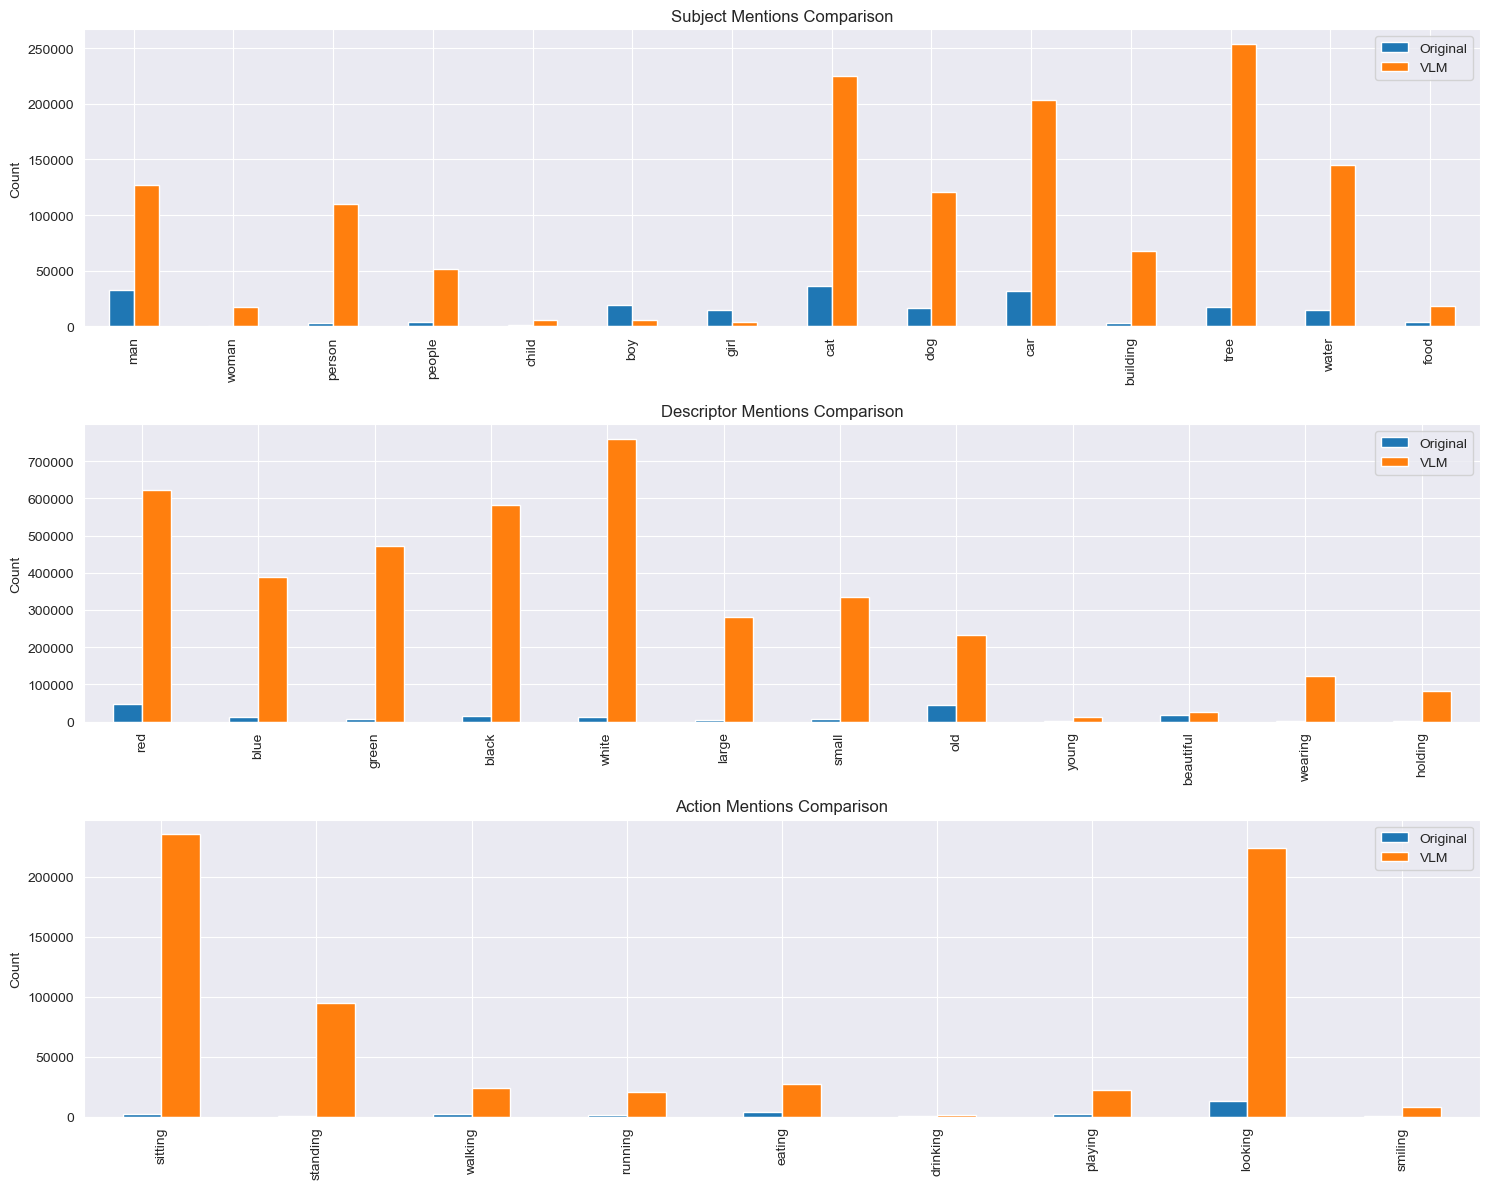

In [7]:
# Content analysis - detect common subjects and descriptors
import re

# Define patterns for common subjects and descriptors
subjects = ['man', 'woman', 'person', 'people', 'child', 'boy', 'girl', 'cat', 'dog', 'car', 'building', 'tree', 'water', 'food']
descriptors = ['red', 'blue', 'green', 'black', 'white', 'large', 'small', 'old', 'young', 'beautiful', 'wearing', 'holding']
actions = ['sitting', 'standing', 'walking', 'running', 'eating', 'drinking', 'playing', 'looking', 'smiling']

def count_patterns(text_series, patterns):
    """Count occurrences of patterns in text series"""
    results = {}
    for pattern in patterns:
        count = text_series.str.contains(pattern, case=False, na=False).sum()
        results[pattern] = count
    return results

# Analyze subjects, descriptors, and actions
print("Subject Analysis:")
original_subjects = count_patterns(df['original_caption'], subjects)
vlm_subjects = count_patterns(df['vlm_caption'], subjects)

for subject in subjects:
    orig_count = original_subjects[subject]
    vlm_count = vlm_subjects[subject]
    print(f"{subject}: Original={orig_count}, VLM={vlm_count}, Diff={vlm_count-orig_count}")

print("\nDescriptor Analysis:")
original_descriptors = count_patterns(df['original_caption'], descriptors)
vlm_descriptors = count_patterns(df['vlm_caption'], descriptors)

for desc in descriptors:
    orig_count = original_descriptors[desc]
    vlm_count = vlm_descriptors[desc]
    print(f"{desc}: Original={orig_count}, VLM={vlm_count}, Diff={vlm_count-orig_count}")

print("\nAction Analysis:")
original_actions = count_patterns(df['original_caption'], actions)
vlm_actions = count_patterns(df['vlm_caption'], actions)

for action in actions:
    orig_count = original_actions[action]
    vlm_count = vlm_actions[action]
    print(f"{action}: Original={orig_count}, VLM={vlm_count}, Diff={vlm_count-orig_count}")

# Create comparison visualization
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))

# Subjects comparison
subjects_df = pd.DataFrame({'Original': [original_subjects[s] for s in subjects], 
                           'VLM': [vlm_subjects[s] for s in subjects]}, 
                          index=subjects)
subjects_df.plot(kind='bar', ax=ax1)
ax1.set_title('Subject Mentions Comparison')
ax1.set_ylabel('Count')
ax1.legend()

# Descriptors comparison
descriptors_df = pd.DataFrame({'Original': [original_descriptors[d] for d in descriptors], 
                              'VLM': [vlm_descriptors[d] for d in descriptors]}, 
                             index=descriptors)
descriptors_df.plot(kind='bar', ax=ax2)
ax2.set_title('Descriptor Mentions Comparison')
ax2.set_ylabel('Count')
ax2.legend()

# Actions comparison
actions_df = pd.DataFrame({'Original': [original_actions[a] for a in actions], 
                          'VLM': [vlm_actions[a] for a in actions]}, 
                         index=actions)
actions_df.plot(kind='bar', ax=ax3)
ax3.set_title('Action Mentions Comparison')
ax3.set_ylabel('Count')
ax3.legend()

plt.tight_layout()
plt.show()